# NN


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing

In [ ]:
train_data = pd.read_csv('new_train_data.csv')
test_data = pd.read_csv('new_test_data.csv')

In [ ]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [ ]:
num_cols = all_features.columns[all_features.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
all_features[num_cols] = preprocessing.scale(all_features[num_cols])
all_features = all_features.fillna(0)

In [ ]:
n_train = train_data.shape[0]
train_features = all_features[:n_train].values.astype(float)
test_features = all_features[n_train:].values.astype(float)
train_labels = train_data.time_to_eruption.values.astype(float).reshape((-1, 1))

In [ ]:
from torch.utils.data import Dataset, DataLoader

class Volcano_DataSet(Dataset):
    def __init__(self, train_features, train_labels):
        super().__init__()
        self.train_features = train_features
        self.train_labels = train_labels

    def __len__(self):
        return len(self.train_features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.train_features[idx], self.train_labels[idx])

In [ ]:
import torch
from torch import nn
import torchvision.models as models

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        hidden_1 = 256
        hidden_2 = 256
        hidden_3 = 256
        self.model = nn.Sequential(nn.Linear(input_dim, hidden_1),
                                   nn.Dropout(0.5),
                                    nn.ReLU(),
                                    nn.Linear(hidden_1, hidden_2),
                                    nn.ReLU(),
                                    nn.Linear(hidden_1, hidden_2),
                                    nn.ReLU(),
                                    nn.Linear(hidden_3, output_dim))

    def forward(self, xb):
        xb = self.model(xb)
        return xb

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

criterion = RMSELoss()


In [ ]:
class VarLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.myloss = nn.L1Loss()
        
    def forward(self, yhat, y):
        #yhat[yhat < 1] = 1
        return torch.mean(torch.abs(torch.div(torch.sub(y,yhat),y)))
        

In [ ]:
class Log_RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

        
    def forward(self, yhat, y):
        yhat[yhat < 1] = 1
        return torch.sqrt(torch.mean(torch.square(torch.sub(torch.log(y),torch.log(yhat)))))

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, lr, batch_size):
    train_ls, test_ls = [], []
    train_dataset = Volcano_DataSet(train_features, train_labels)
    train_iter = DataLoader(train_dataset, batch_size, shuffle=True)
    # The Adam optimization algorithm is used here.
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = VarLoss()

    for epoch in range(num_epochs):
        for X, y in train_iter:
            yhat = net(X.float())
            loss = criterion(yhat, y.float())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_ls.append(loss)
        if test_labels is not None:
            test_y_hat = net(torch.from_numpy(test_features).float())
            test_ls.append(criterion(test_y_hat, torch.from_numpy(test_labels).float()))
    return train_ls, test_ls

In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0]
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = np.concatenate((X_train, X_part), axis=0)
            y_train = np.concatenate((y_train, y_part), axis=0)
    return X_train, y_train, X_valid, y_valid

In [ ]:
from matplotlib import pyplot as plt
from IPython import display

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    """Plot x and log(y)."""

    def set_figsize(figsize=(3.5, 2.5)):
        """Set matplotlib figure size."""
        display.set_matplotlib_formats('svg')
        plt.rcParams['figure.figsize'] = figsize

    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()

In [ ]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = MLP(all_features.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'mse',
                        range(1, num_epochs + 1), valid_ls,
                        ['train', 'valid'])
        print('fold %d, train mse: %f, valid mse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

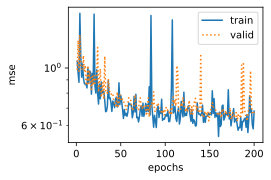

fold 0, train mse: 0.681873, valid mse: 0.676840
fold 1, train mse: 0.635180, valid mse: 0.804586
fold 2, train mse: 0.580431, valid mse: 0.619451
fold 3, train mse: 0.858824, valid mse: 0.865733
fold 4, train mse: 0.680289, valid mse: 0.762740
5-fold validation: avg train rmse: 0.687319, avg valid rmse: 0.745870


In [ ]:
k, num_epochs, lr, batch_size = 5, 200, 0.5, 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

In [ ]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, batch_size):
    net = MLP(all_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, batch_size)
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    # apply the network to the test set
    preds = net(torch.from_numpy(test_features).float()).data.numpy()
    # reformat it for export to Kaggle
    test_data['time_to_eruption'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['segment_id'], test_data['time_to_eruption']], axis=1)
    submission.to_csv('submission.csv', index=False)

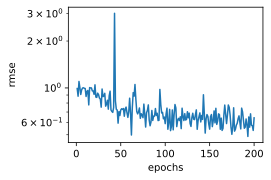

train rmse 0.642306


In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, batch_size)